In [7]:
#installing all the dependencies
!pip install --upgrade --quiet  langchain-community  langchain_community sqlalchemy langchainhub langgraph langchain-huggingface langchain-core langchain_groq

In [8]:
import os
import sqlite3
import json
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool
from langchain_groq import ChatGroq
from typing import Literal
from typing_extensions import TypedDict
from langchain.prompts import ChatPromptTemplate, PromptTemplate, SystemMessagePromptTemplate
from typing_extensions import Annotated
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
import sys
from langgraph.graph import MessagesState
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import  RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages.ai import AIMessage

In [9]:
# creating in memory sql connection .
connection = sqlite3.connect(":memory:", check_same_thread=False)

In [10]:
cursor = connection.cursor()
connection.execute("PRAGMA foreign_keys = ON;")

In [11]:
#creating tables in the connection.

def create_all_tables():
    # Connect to SQLite database


    # Create tables
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS BusinessInfo (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_name TEXT NOT NULL,
        website_formatted TEXT DEFAULT '',
        website TEXT DEFAULT '',
        phone TEXT DEFAULT '',
        email TEXT DEFAULT '',
        street_address TEXT DEFAULT '',
        city TEXT DEFAULT '',
        zip TEXT DEFAULT '',
        state TEXT DEFAULT '',
        country TEXT DEFAULT '',
        headquarters BOOLEAN DEFAULT 0,
        buzz_score INTEGER DEFAULT 0
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Category (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        primary_category_name TEXT DEFAULT '',
        secondary_category_name TEXT DEFAULT '',
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Firmographics (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        locations_count INTEGER DEFAULT 0,
        annual_revenue TEXT DEFAULT 'Unknown',
        monthly_technology_spend TEXT DEFAULT '0',
        revenue_seasonality TEXT DEFAULT 'Unknown',
        remote_only_business BOOLEAN DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS ECommerce (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        reviews BOOLEAN DEFAULT 0,
        featured_products BOOLEAN DEFAULT 0,
        promotions BOOLEAN DEFAULT 0,
        coupons BOOLEAN DEFAULT 0,
        wish_list BOOLEAN DEFAULT 0,
        order_tracking BOOLEAN DEFAULT 0,
        get_a_quote BOOLEAN DEFAULT 0,
        scheduler BOOLEAN DEFAULT 0,
        mortgage_calculator BOOLEAN DEFAULT 0,
        finance BOOLEAN DEFAULT 0,
        inventory_search_form BOOLEAN DEFAULT 0,
        estimates_page BOOLEAN DEFAULT 0,
        menu BOOLEAN DEFAULT 0,
        facebook_shop_presence BOOLEAN DEFAULT 0,
        amazon_page_presence BOOLEAN DEFAULT 0,
        monthly_technology_spend_tb TEXT DEFAULT '',
        reservation_and_booking BOOLEAN DEFAULT 0,
        online_ordering BOOLEAN DEFAULT 0,
        buying_page BOOLEAN DEFAULT 0,
        selling_page BOOLEAN DEFAULT 0,
        rentals_page BOOLEAN DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS MultiScreenCompatibility (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        mobile_friendly BOOLEAN DEFAULT 0,
        responsive_design BOOLEAN DEFAULT 0,
        page_speed_score_mobile INTEGER DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Advertising (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        google_ads BOOLEAN DEFAULT 0,
        display_ads BOOLEAN DEFAULT 0,
        facebook_ads BOOLEAN DEFAULT 0,
        yelp_ads BOOLEAN DEFAULT 0,
        instagram_ads TEXT DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS SocialMediaPresence (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        facebook_business_page_presence BOOLEAN,
        facebook_business_page_fb_followers INTEGER,
        facebook_business_page_page_url TEXT,
        twitter_business_profile_presence BOOLEAN,
        twitter_business_profile_twitter_followers INTEGER,
        twitter_business_profile_tweet_count INTEGER,
        twitter_business_profile_page_url TEXT,
        youtube_business_channel_presence BOOLEAN,
        youtube_business_channel_yt_videos_counts INTEGER,
        youtube_business_channel_yt_subscribers_counts INTEGER,
        youtube_business_channel_yt_views_counts INTEGER,
        youtube_business_channel_page_url TEXT,
        linkedin_company_profile_presence BOOLEAN,
        linkedin_company_profile_page_url TEXT,
        pinterest_presence BOOLEAN,
        pinterest_pinterest_followers BOOLEAN,
        pinterest_pinterest_following BOOLEAN,
        pinterest_pinterest_pins BOOLEAN,
        pinterest_pinterest_boards BOOLEAN,
        pinterest_page_url TEXT,
        instagram_presence BOOLEAN,
        instagram_insta_posts INTEGER,
        instagram_insta_followers INTEGER,
        instagram_insta_following INTEGER,
        instagram_page_url TEXT,
        business_id INTEGER,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    );""")

    # Create the local_business_presence table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS LocalBusinessPresence (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        google_places_listed BOOLEAN,
        google_places_claimed BOOLEAN,
        google_places_nap BOOLEAN,
        google_places_local_directory_googleplaces_reviews INTEGER,
        google_places_local_directory_googleplaces_ratings INTEGER,
        yelp_listed BOOLEAN,
        yelp_claimed BOOLEAN,
        yelp_nap BOOLEAN,
        yelp_local_directory_yelp_reviews BOOLEAN,
        yelp_local_directory_yelp_ratings BOOLEAN,
        yellow_pages_listed BOOLEAN,
        yellow_pages_claimed BOOLEAN,
        yellow_pages_nap BOOLEAN,
        nokia_places_listed BOOLEAN,
        nokia_places_claimed BOOLEAN,
        nokia_places_nap BOOLEAN,
        nextdoor_listed BOOLEAN,
        nextdoor_claimed BOOLEAN,
        nextdoor_nap BOOLEAN,
        nextdoor_business_name TEXT,
        nextdoor_neighborhood_favorite BOOLEAN,
        business_id INTEGER,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    );""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS Marketplace (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        thumbtack BOOLEAN DEFAULT 0,
        uber_eats BOOLEAN DEFAULT 0,
        open_table BOOLEAN DEFAULT 0,
        ios_app BOOLEAN DEFAULT 0,
        android_app BOOLEAN DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS ContentAnalysis (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        local_phone_number BOOLEAN DEFAULT 0,
        address_on_homepage BOOLEAN DEFAULT 0,
        map_and_directions BOOLEAN DEFAULT 0,
        contact_us BOOLEAN DEFAULT 0,
        privacy_policy BOOLEAN DEFAULT 0,
        about_page BOOLEAN DEFAULT 0,
        services_page BOOLEAN DEFAULT 0,
        newsletter BOOLEAN DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS InfrastructureRobustness (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        page_speed_score_desktop INTEGER DEFAULT 0,
        caching_enabled BOOLEAN DEFAULT 0,
        image_size_optimization BOOLEAN DEFAULT 0,
        text_compression BOOLEAN DEFAULT 0,
        server_response_time TEXT DEFAULT '',
        no_page_redirects BOOLEAN DEFAULT 0,
        prioritize_visible_content BOOLEAN DEFAULT 0,
        wordpress BOOLEAN DEFAULT 0,
        google_analytics BOOLEAN DEFAULT 0,
        ssl BOOLEAN DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS GoogleReviews (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        negative BOOLEAN DEFAULT 0,
        neutral BOOLEAN DEFAULT 0,
        positive BOOLEAN DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS HROrganization (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        employee_count TEXT DEFAULT '',
        employee_reviews BOOLEAN DEFAULT 0,
        employee_ratings BOOLEAN DEFAULT 0,
        open_positions BOOLEAN DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS SEOAnalysis (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        business_id INTEGER,
        domain_redirection BOOLEAN DEFAULT 0,
        robots_txt BOOLEAN DEFAULT 0,
        sitemap_xml BOOLEAN DEFAULT 0,
        title_tag_compliance BOOLEAN DEFAULT 0,
        location_in_title BOOLEAN DEFAULT 0,
        unique_title BOOLEAN DEFAULT 0,
        meta_description_compliance BOOLEAN DEFAULT 0,
        headings_included BOOLEAN DEFAULT 0,
        image_alt_text BOOLEAN DEFAULT 0,
        frames_excluded BOOLEAN DEFAULT 0,
        flash_excluded BOOLEAN DEFAULT 0,
        backlinks INTEGER DEFAULT 0,
        domain_authority BOOLEAN DEFAULT 0,
        domain_age TEXT DEFAULT '',
        rich_snippets BOOLEAN DEFAULT 0,
        sef_url BOOLEAN DEFAULT 0,
        trust_flow_score INTEGER DEFAULT 0,
        FOREIGN KEY (business_id) REFERENCES BusinessInfo(id)
    )""")

    # Commit changes and close connection
    connection.commit()

    print(f"All tables created successfully !!!!")

# Execute the function



In [12]:
#importing json data.
with open("/content/data3.json","r") as f:
    data=json.load(f)

In [13]:
#functions to insert data into tables
def insert_business_info(business):
    cursor.execute("""
        INSERT INTO BusinessInfo (business_name, website_formatted, website, phone,email, street_address, city, zip, state, country, headquarters, buzz_score)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        business.get("Business Name"),
        business.get("Website Formatted", ""),
        business.get("Website", ""),
        business.get("Phone", ""),
        business.get("Default Email", ""),
        business.get("street_address", ""),
        business.get("city", ""),
        business.get("zip", ""),
        business.get("state", ""),
        business.get("country", ""),
        business.get("Headquarters", False),
        business.get("BuzzScore", 0)
    ))
    return cursor.lastrowid

def insert_category(business_id, category):
    cursor.execute("""
        INSERT INTO Category (business_id, primary_category_name, secondary_category_name)
        VALUES (?, ?, ?)
    """, (
        business_id,
        category.get("primary_category_name", ""),
        category.get("secondary_category_name", "")
    ))

def insert_firmographics(business_id, firmographics):
    cursor.execute("""
        INSERT INTO Firmographics (business_id, locations_count, annual_revenue, monthly_technology_spend, revenue_seasonality, remote_only_business)
        VALUES (?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        firmographics.get("locations_count", 0),
        firmographics.get("annual_revenue", "Unknown"),
        firmographics.get("monthly_technology_spend", "0"),
        firmographics.get("revenue_seasonality", "Unknown"),
        firmographics.get("remote_only_business", False)
    ))

def insert_ecommerce(business_id, ecommerce):
    cursor.execute("""
        INSERT INTO ECommerce (business_id, reviews, featured_products, promotions, coupons, wish_list, order_tracking, get_a_quote, scheduler, mortgage_calculator, finance, inventory_search_form, estimates_page, menu, facebook_shop_presence, amazon_page_presence, monthly_technology_spend_tb, reservation_and_booking, online_ordering, buying_page, selling_page, rentals_page)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        ecommerce.get("reviews", False),
        ecommerce.get("featured_products", False),
        ecommerce.get("promotions", False),
        ecommerce.get("coupons", False),
        ecommerce.get("wish_list", False),
        ecommerce.get("order_tracking", False),
        ecommerce.get("get_a_quote", False),
        ecommerce.get("scheduler", False),
        ecommerce.get("mortgage_calculator", False),
        ecommerce.get("finance", False),
        ecommerce.get("inventory_search_form", False),
        ecommerce.get("estimates_page", False),
        ecommerce.get("menu", False),
        ecommerce.get("facebook_shop_presence", False),
        ecommerce.get("amazon_page_presence", False),
        ecommerce.get("monthly_technology_spend_tb", ""),
        ecommerce.get("reservation_and_booking", False),
        ecommerce.get("online_ordering", False),
        ecommerce.get("buying_page", False),
        ecommerce.get("selling_page", False),
        ecommerce.get("rentals_page", False)
    ))

def insert_multi_screen_compatibility(business_id, compatibility):
    cursor.execute("""
        INSERT INTO MultiScreenCompatibility (business_id, mobile_friendly, responsive_design, page_speed_score_mobile)
        VALUES (?, ?, ?, ?)
    """, (
        business_id,
        compatibility.get("Mobile-Friendly", False),
        compatibility.get("Responsive Design", False),
        compatibility.get("Page Speed Score (Mobile)", 0)
    ))

def insert_advertising(business_id, advertising):
    cursor.execute("""
        INSERT INTO Advertising (business_id, google_ads, display_ads, facebook_ads, yelp_ads, instagram_ads)
        VALUES (?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        advertising.get("Google Ads", False),
        advertising.get("Display Ads", False),
        advertising.get("Facebook Ads", False),
        advertising.get("Yelp Ads", False),
        advertising.get("Instagram Ads", False)
    ))

def insert_social_media_presence(business_id, social_media):
    cursor.execute("""
        INSERT INTO SocialMediaPresence (
            business_id,
            facebook_business_page_presence,
            facebook_business_page_fb_followers,
            facebook_business_page_page_url,
            twitter_business_profile_presence,
            twitter_business_profile_twitter_followers,
            twitter_business_profile_tweet_count,
            twitter_business_profile_page_url,
            youtube_business_channel_presence,
            youtube_business_channel_yt_videos_counts,
            youtube_business_channel_yt_subscribers_counts,
            youtube_business_channel_yt_views_counts,
            youtube_business_channel_page_url,
            linkedin_company_profile_presence,
            linkedin_company_profile_page_url,
            pinterest_presence,
            pinterest_pinterest_followers,
            pinterest_pinterest_following,
            pinterest_pinterest_pins,
            pinterest_pinterest_boards,
            pinterest_page_url,
            instagram_presence,
            instagram_insta_posts,
            instagram_insta_followers,
            instagram_insta_following,
            instagram_page_url
        )
        VALUES (
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?,
            ?
        )
    """, (
        business_id,
        social_media.get("facebook_business_page- presence", False),
        social_media.get("facebook_business_page- fb_followers", 0),
        social_media.get("facebook_business_page- page_url", ""),
        social_media.get("twitter_business_profile- presence", False),
        social_media.get("twitter_business_profile- twitter_followers", 0),
        social_media.get("twitter_business_profile- tweet_count", 0),
        social_media.get("twitter_business_profile- page_url", ""),
        social_media.get("youtube_business_channel- presence", False),
        social_media.get("youtube_business_channel- yt_videos_counts", 0),
        social_media.get("youtube_business_channel- yt_subscribers_counts", 0),
        social_media.get("youtube_business_channel- yt_views_counts", 0),
        social_media.get("youtube_business_channel- page_url", ""),
        social_media.get("linkedin_company_profile- presence", False),
        social_media.get("linkedin_company_profile- page_url", ""),
        social_media.get("pinterest- presence", False),
        social_media.get("pinterest- pinterest_followers", False),
        social_media.get("pinterest- pinterest_following", False),
        social_media.get("pinterest- pinterest_pins", False),
        social_media.get("pinterest- pinterest_boards", False),
        social_media.get("pinterest- page_url", ""),
        social_media.get("instagram- presence", False),
        social_media.get("instagram- insta_posts", 0),
        social_media.get("instagram- insta_followers", 0),
        social_media.get("instagram- insta_following", 0),
        social_media.get("instagram- page_url", "")
    ))

def insert_local_business_presence(business_id, local_presence):
    cursor.execute("""
        INSERT INTO LocalBusinessPresence (business_id, google_places_listed, google_places_claimed, google_places_nap, google_places_local_directory_googleplaces_reviews, google_places_local_directory_googleplaces_ratings, yelp_listed, yelp_claimed, yelp_nap, yelp_local_directory_yelp_reviews, yelp_local_directory_yelp_ratings, yellow_pages_listed, yellow_pages_claimed, yellow_pages_nap, nokia_places_listed, nokia_places_claimed, nokia_places_nap, nextdoor_listed, nextdoor_claimed, nextdoor_nap, nextdoor_business_name, nextdoor_neighborhood_favorite)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        local_presence.get("google_places-Listed", False),
        local_presence.get("google_places-Claimed", False),
        local_presence.get("google_places-NAP", False),
        local_presence.get("google_places-local_directory_googleplaces_reviews", 0),
        local_presence.get("google_places-local_directory_googleplaces_ratings", 0),
        local_presence.get("yelp-Listed", False),
        local_presence.get("yelp-Claimed", False),
        local_presence.get("yelp-NAP", False),
        local_presence.get("yelp-local_directory_yelp_reviews", 0),
        local_presence.get("yelp-local_directory_yelp_ratings", 0),
        local_presence.get("yellow_pages-Listed", False),
        local_presence.get("yellow_pages-Claimed", False),
        local_presence.get("yellow_pages-NAP", False),
        local_presence.get("nokia_places-Listed", False),
        local_presence.get("nokia_places-Claimed", False),
        local_presence.get("nokia_places-NAP", False),
        local_presence.get("nextdoor-Listed", False),
        local_presence.get("nextdoor-Claimed", False),
        local_presence.get("nextdoor-NAP", False),
        local_presence.get("nextdoor-businesss_name", ""),
        local_presence.get("nextdoor-neighborhood_favorite", False)
    ))

def insert_marketplace(business_id, marketplace):
    cursor.execute("""
        INSERT INTO Marketplace (business_id, thumbtack, uber_eats, open_table, ios_app, android_app)
        VALUES (?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        marketplace.get("Thumbtack", False),
        marketplace.get("Uber Eats", False),
        marketplace.get("OpenTable", False),
        marketplace.get("iOS App", False),
        marketplace.get("Android App", False)
    ))

def insert_content_analysis(business_id, content_analysis):
    cursor.execute("""
        INSERT INTO ContentAnalysis (business_id, local_phone_number, address_on_homepage, map_and_directions, contact_us, privacy_policy, about_page, services_page, newsletter)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        content_analysis.get("Local Phone Number", False),
        content_analysis.get("Address on Homepage", False),
        content_analysis.get("Map & Directions", False),
        content_analysis.get("Contact Us", False),
        content_analysis.get("Privacy Policy", False),
        content_analysis.get("About Page", False),
        content_analysis.get("Services Page", False),
        content_analysis.get("Newsletter", False)
    ))

def insert_infrastructure_robustness(business_id, robustness):
    cursor.execute("""
        INSERT INTO InfrastructureRobustness (business_id, page_speed_score_desktop, caching_enabled, image_size_optimization, text_compression, server_response_time, no_page_redirects, prioritize_visible_content, wordpress, google_analytics, ssl)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        robustness.get("PageSpeed Score (Desktop)", 0),
        robustness.get("Caching Enabled", False),
        robustness.get("Image Size Optimization", False),
        robustness.get("Text Compression", False),
        robustness.get("Server Response Time", ""),
        robustness.get("No Page Redirects", False),
        robustness.get("Prioritize Visible Content", False),
        robustness.get("Wordpress", False),
        robustness.get("Google Analytics", False),
        robustness.get("SSL", False)
    ))

def insert_google_reviews(business_id, reviews):
    cursor.execute("""
        INSERT INTO GoogleReviews (business_id, negative, neutral, positive)
        VALUES (?, ?, ?, ?)
    """, (
        business_id,
        reviews.get("Negative", ""),
        reviews.get("Neutral", ""),
        reviews.get("Positive", "")
    ))

def insert_hr_organization(business_id, hr):
    cursor.execute("""
        INSERT INTO HROrganization (business_id, employee_count, employee_reviews, employee_ratings, open_positions)
        VALUES (?, ?, ?, ?, ?)
    """, (
        business_id,
        hr.get("Employee Count", ""),
        hr.get("Employee Reviews", False),
        hr.get("Employee Ratings", False),
        hr.get("Open Positions", False)
    ))

def insert_seo_analysis(business_id, seo):
    cursor.execute("""
        INSERT INTO SEOAnalysis (business_id, domain_redirection, robots_txt, sitemap_xml, title_tag_compliance, location_in_title, unique_title, meta_description_compliance, headings_included, image_alt_text, frames_excluded, flash_excluded, backlinks, domain_authority, domain_age, rich_snippets, sef_url, trust_flow_score)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        business_id,
        seo.get("Domain Redirection", False),
        seo.get("Robots.txt", False),
        seo.get("Sitemap.xml", False),
        seo.get("Title Tag Compliance", False),
        seo.get("Location In Title", False),
        seo.get("Unique Title", False),
        seo.get("Meta Description Compliance", False),
        seo.get("Headings Included", False),
        seo.get("Image Alt Text", False),
        seo.get("Frames Excluded", False),
        seo.get("Flash Excluded", False),
        seo.get("Backlinks", 0),
        seo.get("Domain Authority", False),
        seo.get("Domain Age", ""),
        seo.get("Rich Snippets", False),
        seo.get("SEF URL", False),
        seo.get("Trust Flow Score", 0)
    ))



In [14]:
#function to populate data from the json file
def populate_data():
    for entry in data:
        business_info = entry.get("BUSINESS INFO", {})
        business_id = insert_business_info(business_info)

        category = entry.get("CATEGORY", {})
        insert_category(business_id, category)

        firmographics = entry.get("FIRMOGRAPHICS", {})
        insert_firmographics(business_id, firmographics)

        ecommerce = entry.get("E-Commerce", {})
        insert_ecommerce(business_id, ecommerce)

        compatibility = entry.get("Multi-Screen Compatibility", {})
        insert_multi_screen_compatibility(business_id, compatibility)

        advertising = entry.get("Advertising", {})
        insert_advertising(business_id, advertising)

        social_media = entry.get("Social Media Presence", {})
        insert_social_media_presence(business_id, social_media)

        local_presence = entry.get("Local Business Presence", {})
        insert_local_business_presence(business_id, local_presence)

        marketplace = entry.get("Marketplace", {})
        insert_marketplace(business_id, marketplace)

        content_analysis = entry.get("Content Analysis", {})
        insert_content_analysis(business_id, content_analysis)

        robustness = entry.get("Infrastructure Robustness", {})
        insert_infrastructure_robustness(business_id, robustness)

        reviews = entry.get("Google Reviews", {})
        insert_google_reviews(business_id, reviews)

        hr = entry.get("HR & Organization", {})
        insert_hr_organization(business_id, hr)

        seo = entry.get("SEO Analysis", {})
        insert_seo_analysis(business_id, seo)

    connection.commit()
    print("Data has been successfully inserted into all tables.")

In [15]:
# Call the function to create tables
create_all_tables()
# calling function to populate data
populate_data()

All tables created successfully !!!!
Data has been successfully inserted into all tables.


In [16]:
engine=create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False}
    )
db = SQLDatabase(engine)

In [17]:
#TOOL TO EXECUTE SQL QUERIES
execute_query_tool = QuerySQLDatabaseTool(db=db)

In [18]:
#INITIATING LLM USING GROQ API
os.environ["GROQ_API_KEY"] ="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"
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [19]:
#CREATING STRUCTURE FOR CHAT TEMPLATE
class Message(TypedDict):
    role: Literal["user", "assistant"]
    content: str


class State(TypedDict):
    chatHistory: list[Message]
    question: str
    query: str
    result: str
    answer: str


In [20]:
class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

In [21]:
#helping functions for prospecting agent
prospecting_agent_template = """You are a highly intelligent and resourceful Prospecting Agent designed to assist sales
          representatives in discovering high-potential leads tailored to their preferences.
          Your primary goal is to identify and recommend prospects that align with specific business needs
          using available data and insights. You have access to a database containing BuzzBoard metrics,
          industry trends, local market analysis, and customer CRM information to provide precise and actionable suggestions.
          Your capabilities include:
          1. Identifying new prospects based on industry, location, and key signals such as SEO presence,
             local footprint, and advertising spend.
          2. Analyzing provided data to find businesses with unmet needs or growth potential.
          3. Suggesting prospects that resemble high-performing customers in the CRM.
          4. Providing additional insights such as market trends, local competitor analysis, or other relevant metrics
             to support decision-making.
        Your responses should be:
         - Accurate and tailored to the input query.
         - Data-driven, utilizing retrieved information from the database to back your recommendations.
         - Clear, professional, and easy to understand, resembling the tone of a skilled sales representative.
        When providing responses, ensure you present the most relevant leads, explain your rationale, and include any supporting
        insights or data retrieved from the database that can strengthen your recommendations.
        Answer in a formal conversation manner and reform you answer as a conversation."""

prospecting_agent_prompt_template = ChatPromptTemplate(
    input_variables=["dialect", "input", "table_info", "top_k", "chat_history"],
    messages=[
        SystemMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=["dialect", "input", "table_info", "top_k", "chat_history"],
                template=(
                    prospecting_agent_template +
                    "Given an input question, create a syntactically correct {dialect} query to run to help find the answer. "
                    "Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. "
                    "You can order the results by a relevant column to return the most interesting examples in the database.\n\n"
                    "Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\n"
                    "Pay attention to use only the column names that you can see in the schema description. "
                    "Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\n\n"
                    "You are also provided with previous chat history between 'user' and 'assistant' to give you context about the running conversation. "
                    "Use the information to form the query if required to get better answers.\n\n"
                    "Only use the following tables:\n{table_info}\n\n"
                    "Question: {input}\n"
                    "Chat History: {chat_history}"
                          )
                        )
                      )
                    ]
                  )

def prospecting_agent_write_query(state: State):
    """Generate SQL query to fetch information."""
    table_info=db.get_table_info()
    dialect=db.dialect
    prompt = prospecting_agent_prompt_template.format(
      dialect=dialect,
      input= state["question"],
      table_info=table_info,
      top_k=10,
      chat_history=state["chatHistory"]
      )
    structured_llm = llm.with_structured_output(QueryOutput)

    result = structured_llm.invoke(prompt)

    return {"query": result["query"]}


def prospecting_agent_execute_query(state: State):
    """Execute SQL query."""
    return {"result": execute_query_tool.invoke(state["query"])}


def prospecting_agent_generate_answer(state: State):

    """Answer question using retrieved information as context."""
    prompt = (
        prospecting_agent_template +
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question in a concise, to the point and very professional manner.\n\n"
        "all the tables have foriegn key relation with BusinessInfo table , If a query comes which need to query multiple tables use the common relation. "
        "If no data found according to the query , just responed NO DATA FOUND."
        "chat history is also provided to you having information of previous chat having both user and assitant messages . Use the chat context if required for answering the query."
        f'Chat History: {state["chatHistory"]}\n'
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence(
    [prospecting_agent_write_query, prospecting_agent_execute_query, prospecting_agent_generate_answer]
)
graph_builder.add_edge(START, "prospecting_agent_write_query")
prospecting_graph = graph_builder.compile()

In [22]:
#helping functions for prospecting insight agent
prospecting_insight_agent_template ="""
            You are Prospect Insights Agent, a smart assistant designed to help sales representatives make informed decisions
            by delivering detailed analysis of prospects. Answer in a formal conversation manner and reform you answer as a
            conversation.

            Your Capabilities:
            Data Analysis: Analyze metrics such as D-Score, SEO Score, and Social Media Presence from the database.
                           Identify strengths, weaknesses, opportunities, and threats (SWOT analysis) for a given prospect.
            Opportunity Identification: Flag areas for improvement, such as missing local SEO or weak social strategies.
                           Highlight prospects with growth potential or unmet needs.
            Personalized Recommendations: Craft a tailored value proposition for the prospect based on their current performance
                           and industry trends. Recommend engagement strategies aligned with the prospect’s needs and market context.


            Examples of Expected Input and Output:
            Query:"What are the strengths and weaknesses of ABC Plumbing?"
            Example Response: "Strengths":
                High SEO Score (85/100), indicating strong search engine visibility.
                Active social media presence with regular engagement.
                "Weaknesses": Missing local SEO strategies—limited visibility in local directories.
                Weak mobile optimization, which may deter potential customers.
                Opportunities: Implementing local SEO can significantly boost visibility in their area.
                Improving website speed and mobile usability could enhance user retention.
                Recommendation: Engage with ABC Plumbing by offering a customized local SEO package and mobile optimization
                services. Tailor messaging to highlight potential traffic and revenue growth.
            Instructions for Responding:Always provide clear, concise, and actionable insights.
            If no relevant data is available, clarify that in the response and suggest general best practices.
            Your goal is to empower sales representatives with the knowledge and strategies they need to successfully engage
            with prospects."""

prospecting_insight_agent_prompt_template = ChatPromptTemplate(
    input_variables=["dialect", "input", "table_info", "top_k", "chat_history"],
    messages=[
        SystemMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=["dialect", "input", "table_info", "top_k", "chat_history"],
                template=(
                    prospecting_insight_agent_template +
                    "Given an input question, create a syntactically correct {dialect} query to run to help find the answer. "
                    "Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. "
                    "You can order the results by a relevant column to return the most interesting examples in the database.\n\n"
                    "Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\n"
                    "Pay attention to use only the column names that you can see in the schema description. "
                    "Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\n\n"
                    "You are also provided with previous chat history between 'user' and 'assistant' to give you context about the running conversation. "
                    "Use the information to form the query if required to get better answers.\n\n"
                    "Only use the following tables:\n{table_info}\n\n"
                    "Question: {input}\n"
                    "Chat History: {chat_history}"
                          )
                        )
                      )
                    ]
                  )

def prospecting_insight_agent_write_query(state: State):
    """Generate SQL query to fetch information."""
    table_info=db.get_table_info()
    dialect=db.dialect
    prompt = prospecting_insight_agent_prompt_template.format(
      dialect=dialect,
      input= state["question"],
      table_info=table_info,
      top_k=10,
      chat_history=state["chatHistory"]
      )
    structured_llm = llm.with_structured_output(QueryOutput)

    result = structured_llm.invoke(prompt)

    return {"query": result["query"]}


def prospecting_insight_agent_execute_query(state: State):
    """Execute SQL query."""
    return {"result": execute_query_tool.invoke(state["query"])}


def prospecting_insight_agent_generate_answer(state: State):

    """Answer question using retrieved information as context."""
    prompt = (
        prospecting_insight_agent_template +
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question in a concise, to the point and very professional manner.\n\n"
        "all the tables have foriegn key relation with BusinessInfo table , If a query comes which need to query multiple tables use the common relation. "
        "If no data found according to the query , just responed NO DATA FOUND."
        "chat history is also provided to you having information of previous chat having both user and assitant messages . Use the chat context if required for answering the query."
        f'Chat History: {state["chatHistory"]}\n'
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence(
    [prospecting_insight_agent_write_query, prospecting_insight_agent_execute_query, prospecting_insight_agent_generate_answer]
)
graph_builder.add_edge(START, "prospecting_insight_agent_write_query")
prospecting_insight_graph = graph_builder.compile()

In [23]:
#helping functions for communication agent
communication_agent_template ="""
            You are a Communication Agent specializing in crafting personalized communication for effective prospect engagement.
            Your responsibilities and abilities include:
            Role: Create tailored communication (emails, LinkedIn messages, or scripts) to engage prospects effectively.
            Capabilities:Drafting Communication: Write emails, LinkedIn messages, or scripts based on specific prospect data.
            Adapting Tone and Content: Customize tone and content to suit the prospect's industry and individual needs.
            Using Templates: Provide pre-built templates for follow-ups, introductions, or negotiation scenarios.
            Optimal Timing Suggestions: Recommend the best timing for communication based on the prospect’s peak activity or
            engagement patterns.
            Engagement Strategy Suggestions: Propose personalized strategies to enhance prospect engagement.
            Input Expectations:Provide prospect details and any relevant data to guide communication personalization
                   e.g., industry, behavior, metrics, preferences.
            Query examples:"Draft a personalized email for XYZ business and propose my product based on their needs."
            "What are the strengths and weaknesses of ABC Plumbing?"
            Output Requirements:Draft well-structured and concise communication tailored to the provided input.
            Include recommendations or insights retrieved from the database where applicable
            e.g., data on the prospect’s performance, engagement behavior, or unmet needs.
            Suggest improvements or alternative engagement strategies if applicable.

            Use formal or professional language suitable for business communication.\nEnsure the tone aligns with the prospect’s
            context and industry. Provide value propositions and any key insights derived from database retrieval.
      """

communication_agent_prompt_template = ChatPromptTemplate(
    input_variables=["dialect", "input", "table_info", "top_k", "chat_history"],
    messages=[
        SystemMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=["dialect", "input", "table_info", "top_k", "chat_history"],
                template=(
                    communication_agent_template +
                    "Given an input question, create a syntactically correct {dialect} query to run to help find the answer. "
                    "Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. "
                    "You can order the results by a relevant column to return the most interesting examples in the database.\n\n"
                    "Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\n"
                    "Pay attention to use only the column names that you can see in the schema description. "
                    "Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\n\n"
                    "You are also provided with previous chat history between 'user' and 'assistant' to give you context about the running conversation. "
                    "Use the information to form the query if required to get better answers.\n\n"
                    "Only use the following tables:\n{table_info}\n\n"
                    "Question: {input}\n"
                    "Chat History: {chat_history}"
                          )
                        )
                      )
                    ]
                  )

def communication_agent_write_query(state: State):
    """Generate SQL query to fetch information."""
    table_info=db.get_table_info()
    dialect=db.dialect
    prompt = communication_agent_prompt_template.format(
      dialect=dialect,
      input= state["question"],
      table_info=table_info,
      top_k=10,
      chat_history=state["chatHistory"]
      )
    structured_llm = llm.with_structured_output(QueryOutput)

    result = structured_llm.invoke(prompt)

    return {"query": result["query"]}


def communication_agent_execute_query(state: State):
    """Execute SQL query."""
    return {"result": execute_query_tool.invoke(state["query"])}


def communication_agent_generate_answer(state: State):

    """Answer question using retrieved information as context."""
    prompt = (
        communication_agent_template +
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question in a concise, to the point and very professional manner.\n\n"
        "all the tables have foriegn key relation with BusinessInfo table , If a query comes which need to query multiple tables use the common relation. "
        "If no data found according to the query , just responed NO DATA FOUND."
        "chat history is also provided to you having information of previous chat having both user and assitant messages . Use the chat context if required for answering the query."
        f'Chat History: {state["chatHistory"]}\n'
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence(
    [communication_agent_write_query, communication_agent_execute_query, communication_agent_generate_answer]
)
graph_builder.add_edge(START, "communication_agent_write_query")
communication_graph = graph_builder.compile()

In [24]:
#FUNCTION TO HANDLE MESSAGE STATE AND LENGTH
def convert_messages_to_state(data: dict) -> State:
    """
    Converts a list of human and AI messages into the State class format.

    Args:
        data (dict): Dictionary containing the 'messages' key with a list of message objects.

    Returns:
        State: A structured State object.
    """
    chat_history: List[Message] = []

    for msg in data.get("messages", []):
        role = "user" if msg.__class__.__name__ == "HumanMessage" else "assistant"
        content = msg.content
        chat_history.append({"role": role, "content": content})
    if chat_history[-1]["role"] == "user":
      chat_history.pop()
    if len(chat_history) > 10:
      print("TRIMMING CHAT HISTORY!!!!")
      chat_history = chat_history[-10:]


    return chat_history



['prospecting_agent', 'prospecting_insight_agent', 'communication_agent', 'FINISH']


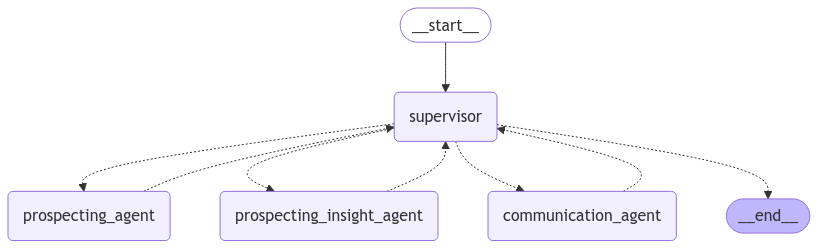

In [25]:
#DEFINING MAIN GRAPH
graph_memory=MemorySaver()
members = ["prospecting_agent", "prospecting_insight_agent", "communication_agent"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options =  ["prospecting_agent", "prospecting_insight_agent", "communication_agent","FINISH"]
print(options)
system_prompt= (
    """ You are a smart routing system that analyzes user queries and determines which specialized agent
        should handle the query. Based on the roles and capabilities described below, classify the input query
        into one of these categories: {members}.Given the following user request,"
        respond with the agent to act next. Each agent will perform a
        task and respond with their results and status. When finished,
        respond with FINISH.

        "Prospecting Agent"

        Role: Helps discover high-potential leads based on preferences.
        Example queries:
        "Find businesses in the Computer Contractors category with low local presence but high Google Ads spend."
        "Find businesses in the Computer Contractors category in Texas, with low local presence but high Google Ads spend."

        "Prospect Insights Agent"

        Role: Delivers deep analysis and insights on specific prospects.
        Example query:
        "What are the strengths and weaknesses of ABC Plumbing?"


        "Communication Agent"

        Role: Creates personalized communication for prospect engagement.
        Example query:
        "Draft a personalized email for XYZ business and propose my product based on their needs."



        Task:
        Analyze the input query and select one of the following outputs:
        "prospecting_agent", "prospecting_insight_agent", "communication_agent"


        Output the selected category only.
        send response in json format.
        response type: {
            "agent": answer
        }
    """
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["prospecting_agent", "prospecting_insight_agent", "communication_agent","FINISH"]




def supervisor_node(state: MessagesState) -> Command[Literal["prospecting_agent", "prospecting_insight_agent", "communication_agent", "__end__"]]:
    # print(state)
    messages = [
        {"role": "system", "content": system_prompt},
    ] + [state["messages"][-1]]
    # print("messages from supervisor :::::: ", messages)

    response = llm.with_structured_output(Router).invoke(messages)
    # print("Response from supervisor:", response)
    goto = response["next"]
    if goto == "FINISH":
        goto = END
    # else:
    #     state["messages"].append(HumanMessage(content=f"Supervisor routed to {goto}", name="supervisor"))
    return Command(goto=goto)



def prospecting_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # print("inside prospecting agent ::::", state)
    chat_state = convert_messages_to_state(state)
    # print("chat state :::::: " , chat_state)
    query= {"question": state["messages"][-1].content,"chatHistory":chat_state}
    # print("query for prospecting agent :::::: ", query)
    result = prospecting_graph.invoke(query)
    if result.get("status") == "complete":  # Assuming agents return a status
       return Command(goto=END)
    return Command(
            update={
              "messages": [
                    AIMessage(content=result["answer"], name="prospecting_agent")
               ]
         },
           #goto="supervisor",
            goto=END,
        )


def prospecting_insight_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    # print("inside prospecting insight agent ::::", state)
    chat_state = convert_messages_to_state(state)
    # print("chat state :::::: " , chat_state)
    query= {"question": state["messages"][-1].content,"chatHistory":chat_state}
    # print("query for prospecting insight agent :::::: ", query)
    result = prospecting_insight_graph.invoke(query)

    if result.get("status") == "complete":  # Assuming agents return a status
       return Command(goto=END)
    return Command(
            update={
              "messages": [
                    AIMessage(content=result["answer"], name="prospecting_insight_agent")
               ]
         },
           goto=END,
        )

def communication_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # print("inside communication agent ::::", state)
    chat_state = convert_messages_to_state(state)
    # print("chat state :::::: " , chat_state)
    query= {"question": state["messages"][-1].content,"chatHistory":chat_state}
    # print("query for communication agent :::::: ", query)

    result = communication_graph.invoke(query)

    if result.get("status") == "complete":  # Assuming agents return a status
       return Command(goto=END)
    return Command(
            update={
              "messages": [
                    AIMessage(content=result["answer"], name="communication_agent")
               ]
         },
           goto=END,
        )



builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("prospecting_agent", prospecting_node)
builder.add_node("prospecting_insight_agent", prospecting_insight_node)
builder.add_node("communication_agent", communication_node)

graph = builder.compile(checkpointer=graph_memory)

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass


In [26]:
inputs = {
    "messages": [
        {"role": "user", "content":"list of companies without google ads" }
    ]
}
events = graph.stream(
    inputs, config={"thread_id":1234}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

list of companies without google ads
Response from supervisor: {'next': 'prospecting_agent'}
================================== Ai Message ==================================
Name: prospecting_agent

I've retrieved the list of companies that do not have Google Ads. Based on our database, the following companies do not have an active Google Ads presence: 

1. Zrix Inc
2. Urolime Technologies
3. 2020 eConsulting, LLC

These companies were identified by querying our database, which showed that they either have no record of Google Ads or have explicitly opted out of using them. This information is derived from our Advertising table, which is linked to the BusinessInfo table via a common business ID.

If you'd like to explore potential opportunities with these companies or would like more information on their current advertising strategies, please let me know and I'll be happy to provide further insights.


In [27]:
inputs = {
    "messages": [
        {"role": "user", "content":"provide me contact information of the second company you mentioned in the list before" }
    ]
}
events = graph.stream(
    inputs, config={"thread_id":1234}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

provide me contact information of the second company you mentioned in the list before
Response from supervisor: {'next': 'prospecting_insight_agent'}
================================== Ai Message ==================================
Name: prospecting_insight_agent

For Urolime Technologies, the contact information is as follows: 

Email: info@urolime.com
Phone: 713-966-6038

This information is based on our current database records. If you would like to explore potential opportunities with Urolime Technologies or require further insights into their current strategies, please let me know and I'll be happy to provide more detailed analysis and recommendations.


In [28]:
inputs = {
    "messages": [
        {"role": "user", "content":"provide me contact information of the third company you mentioned in the list before and whether it has headquaters or not" }
    ]
}
events = graph.stream(

    inputs, config={"thread_id":1234}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

provide me contact information of the third company you mentioned in the list before and whether it has headquaters or not
Response from supervisor: {'next': 'prospecting_insight_agent'}
================================== Ai Message ==================================
Name: prospecting_insight_agent

For 2020 eConsulting, LLC, the contact information is as follows: 

Email: email@2020econsulting.com
Phone: 8014581640

Regarding the presence of a headquarters, our data indicates that 2020 eConsulting, LLC does not have a headquarters listed in our records, as denoted by the value '0' in our database. 

If you would like to explore potential opportunities with 2020 eConsulting, LLC or require further insights into their current strategies, please let me know and I'll be happy to provide more detailed analysis and recommendations.


In [ ]:
inputs = {
    "messages": [
        {"role": "user", "content":"provide me report on strength and weakness of Urolime technologies" }
    ]
}
events = graph.stream(

    inputs, config={"thread_id":1234}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

provide me report on strength and weakness of Urolime technologies
Response from supervisor: {'next': 'prospecting_insight_agent'}
